[View in Colaboratory](https://colab.research.google.com/github/loloaquarius/Coursera_Capstone/blob/master/Final_Assignment_Machine_Learning_Course.ipynb)

<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align = "center"></a>

<h1 align=center><font size = 5> Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv


Redirecting output to ‘wget-log.4’.


### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date']=pd.to_datetime(df['due_date'])
df['effective_date']=pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

/bin/bash: conda: command not found


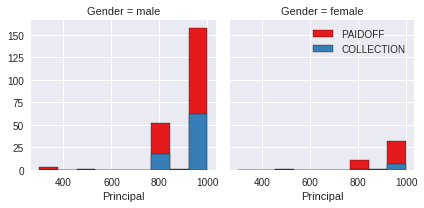

In [8]:
import seaborn as sns

bins=np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

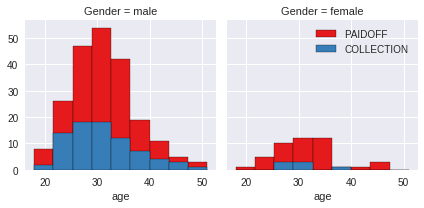

In [9]:
bins=np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

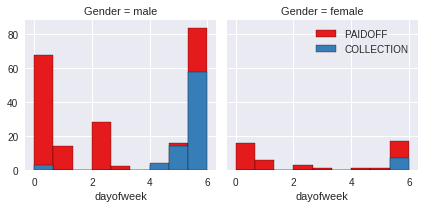

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins=np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend']= df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


**Shuffle rows in dataframe and reindex**

In [0]:
df = df.sample(frac=1).reset_index(drop=True)

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature=df[['Principal','terms','age','Gender','weekend']]
Feature=pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,15,31,0,1,0,0,1
1,1000,7,26,1,0,1,0,0
2,1000,15,28,1,0,0,0,1
3,1000,30,29,1,1,0,0,1
4,1000,30,33,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,15,31,0,1,0,0,1
1,1000,7,26,1,0,1,0,0
2,1000,15,28,1,0,0,0,1
3,1000,30,29,1,1,0,0,1
4,1000,30,33,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458, -0.95911111,  0.01006414, -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458, -1.96168647, -0.81902922,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.48739188,  2.37778177, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 ,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769,  0.34170148, -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

**Import some functions used for split data and measure accuracy:**

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

**Define a function used for plot confusion matrix:**

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Split data set into test set and training set:**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=4)
print('Train set: ',X_train.shape,y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (242, 8) (242,)
Test set:  (104, 8) (104,)


# K Nearest Neighbor(KNN)
Notice: You can find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMx = []
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.71153846, 0.69230769, 0.74038462, 0.74038462, 0.75      ,
       0.75      , 0.75      , 0.75      , 0.75      ])

**Plot model accuracy for Different number of Neighbors**

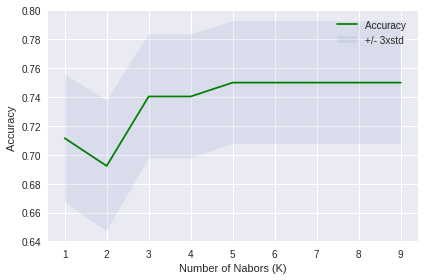

In [26]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [27]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.75 with k= 5


**Plot confusion matrix:**

In [0]:
neigh = KNeighborsClassifier(n_neighbors = 9).fit(X_train,y_train)
yhat_knn = neigh.predict(X_test)

Confusion matrix, without normalization
[[74  3]
 [23  4]]


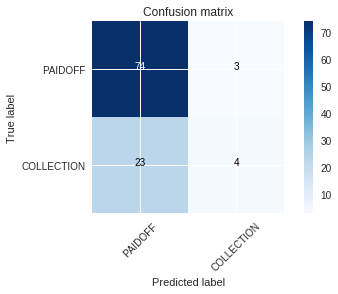

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_knn, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

**Training with whole data set, using k equal 9**

In [0]:
neigh = KNeighborsClassifier(n_neighbors = 9).fit(X,y)

# Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=5)
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [0]:
yhat_tree = tree.predict(X_test)

**Show accuracy of model basing on some methods and plot confusion matrix:**

             precision    recall  f1-score   support

 COLLECTION       0.00      0.00      0.00        27
    PAIDOFF       0.73      0.95      0.82        77

avg / total       0.54      0.70      0.61       104

Confusion matrix, without normalization
[[73  4]
 [27  0]]


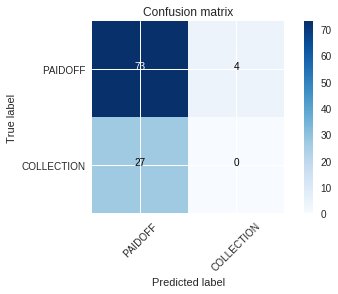

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_tree, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_tree))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

**Training with whole data set**

In [35]:
tree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Support Vector Machine

In [0]:
from sklearn import svm

In [0]:
clf = svm.SVC(kernel='rbf')

In [38]:
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
yhat_SVM = clf.predict(X_test)

**Show accuracy of model basing on some methods and plot confusion matrix:**

             precision    recall  f1-score   support

 COLLECTION       0.33      0.04      0.07        27
    PAIDOFF       0.74      0.97      0.84        77

avg / total       0.64      0.73      0.64       104

Confusion matrix, without normalization
[[75  2]
 [26  1]]


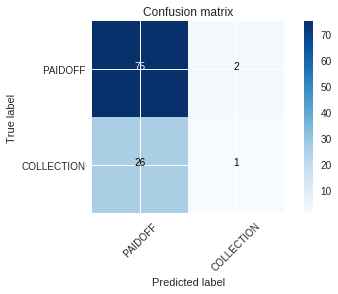

In [40]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_SVM, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_SVM))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

**Training with whole data set**

In [41]:
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
lr = LogisticRegression(C=0.01,solver='liblinear')

In [44]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
yhat_lr = lr.predict(X_test)

**predict_proba** returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X):

In [46]:
yhat_prob = lr.predict_proba(X_test)
yhat_prob

array([[0.34, 0.66],
       [0.32, 0.68],
       [0.35, 0.65],
       [0.46, 0.54],
       [0.42, 0.58],
       [0.34, 0.66],
       [0.3 , 0.7 ],
       [0.31, 0.69],
       [0.48, 0.52],
       [0.46, 0.54],
       [0.35, 0.65],
       [0.3 , 0.7 ],
       [0.48, 0.52],
       [0.48, 0.52],
       [0.48, 0.52],
       [0.46, 0.54],
       [0.47, 0.53],
       [0.44, 0.56],
       [0.45, 0.55],
       [0.47, 0.53],
       [0.47, 0.53],
       [0.36, 0.64],
       [0.25, 0.75],
       [0.47, 0.53],
       [0.35, 0.65],
       [0.31, 0.69],
       [0.42, 0.58],
       [0.39, 0.61],
       [0.39, 0.61],
       [0.35, 0.65],
       [0.45, 0.55],
       [0.46, 0.54],
       [0.35, 0.65],
       [0.33, 0.67],
       [0.42, 0.58],
       [0.29, 0.71],
       [0.42, 0.58],
       [0.42, 0.58],
       [0.44, 0.56],
       [0.35, 0.65],
       [0.31, 0.69],
       [0.34, 0.66],
       [0.45, 0.55],
       [0.42, 0.58],
       [0.31, 0.69],
       [0.35, 0.65],
       [0.48, 0.52],
       [0.36,

**Show accuracy of model basing on some methods and plot confusion matrix:**

             precision    recall  f1-score   support

 COLLECTION       0.33      0.04      0.07        27
    PAIDOFF       0.74      0.97      0.84        77

avg / total       0.64      0.73      0.64       104

Confusion matrix, without normalization
[[75  2]
 [26  1]]


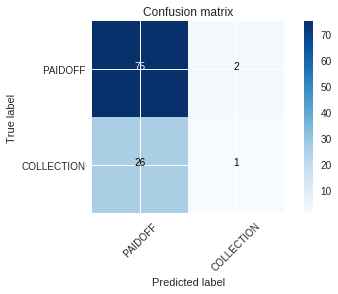

In [47]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_lr, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_lr))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

**Training with whole data set**

In [48]:
lr.fit(X, y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Model Evaluation using Test set

First, download and load the test set:

In [49]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv


Redirecting output to ‘wget-log.5’.


### Load Test set for evaluation 

In [50]:
df = pd.read_csv('loan_test.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [0]:
df['effective_date']=pd.to_datetime(df['effective_date'])
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend']= df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [0]:
Feature=df[['Principal','terms','age','Gender','weekend']]
Feature=pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
X_test = Feature
X_test= preprocessing.StandardScaler().fit(Feature).transform(Feature)
y_test = df['loan_status'].values

In [0]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [0]:
yhat1 = neigh.predict(X_test)
yhat2 = tree.predict(X_test)
yhat3 = clf.predict(X_test)
yhat4 = lr.predict(X_test)

In [55]:
yhat_prob = lr.predict_proba(X_test)
yhat_prob

array([[0.25, 0.75],
       [0.4 , 0.6 ],
       [0.43, 0.57],
       [0.47, 0.53],
       [0.45, 0.55],
       [0.45, 0.55],
       [0.45, 0.55],
       [0.48, 0.52],
       [0.39, 0.61],
       [0.44, 0.56],
       [0.46, 0.54],
       [0.39, 0.61],
       [0.48, 0.52],
       [0.41, 0.59],
       [0.43, 0.57],
       [0.47, 0.53],
       [0.43, 0.57],
       [0.39, 0.61],
       [0.47, 0.53],
       [0.45, 0.55],
       [0.47, 0.53],
       [0.45, 0.55],
       [0.24, 0.76],
       [0.28, 0.72],
       [0.29, 0.71],
       [0.29, 0.71],
       [0.29, 0.71],
       [0.28, 0.72],
       [0.31, 0.69],
       [0.3 , 0.7 ],
       [0.3 , 0.7 ],
       [0.29, 0.71],
       [0.3 , 0.7 ],
       [0.3 , 0.7 ],
       [0.29, 0.71],
       [0.3 , 0.7 ],
       [0.31, 0.69],
       [0.27, 0.73],
       [0.27, 0.73],
       [0.26, 0.74],
       [0.49, 0.51],
       [0.41, 0.59],
       [0.42, 0.58],
       [0.47, 0.53],
       [0.41, 0.59],
       [0.5 , 0.5 ],
       [0.47, 0.53],
       [0.45,

In [56]:
Algorithms = ['KNN','Decision Tree','SVM','Logistic Regression']
Metrics = ['Jaccard','F1-score']
for i, yhat in enumerate([yhat1, yhat2, yhat3, yhat4]):
    for j, metric in enumerate([jaccard_similarity_score(y_test, yhat),f1_score(y_test, yhat,average='micro')]):
        print('Accuracy of ' + Algorithms[i] + ' algorithm using ' + Metrics[j] + 'metric:' + str(round(metric,3)))

Accuracy of KNN algorithm using Jaccardmetric:0.685
Accuracy of KNN algorithm using F1-scoremetric:0.685
Accuracy of Decision Tree algorithm using Jaccardmetric:0.722
Accuracy of Decision Tree algorithm using F1-scoremetric:0.722
Accuracy of SVM algorithm using Jaccardmetric:0.722
Accuracy of SVM algorithm using F1-scoremetric:0.722
Accuracy of Logistic Regression algorithm using Jaccardmetric:0.741
Accuracy of Logistic Regression algorithm using F1-scoremetric:0.741


**Evaluate accuracy of logistic regression using log loss**

In [57]:
print('Accuracy of Logistic Regression algorithm using log loss: {}'.format(log_loss(y_test, yhat_prob)))

Accuracy of Logistic Regression algorithm using log loss: 0.5566084946309207


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.685   | 0.685    | NaN  |
| Decision Tree      | 0.722   | 0.722    | NaN  |
| SVM                | 0.722   | 0.722    | NaN   |
| LogisticRegression | 0.741   | 0.741    | 0.557   |

## Want to learn more?

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: [SPSS Modeler](http://cocl.us/ML0101EN-SPSSModeler).

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at [Watson Studio](https://cocl.us/ML0101EN_DSX)


<hr>
Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>